MorganFingerPrints

In [4]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
import pandas as pd
import numpy as np
from rdkit import Chem
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [3]:

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
import pandas as pd
import numpy as np
from rdkit import Chem
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
# Load datasets
dataseta = pd.read_csv('/Users/iaamir/Desktop/ONLY BRC DDI/pureBRC/b3.csv')
datasetb = pd.read_csv('/Users/iaamir/Desktop/ONLY BRC DDI/pureBRC/datasetb.csv')

# Ensure 'cell' columns are of the same data type in both datasets
dataseta['cell'] = dataseta['cell'].astype(str)
datasetb['cell'] = datasetb['cell'].astype(str)

# Align datasets by 'cell'
# Inner join ensures only matching rows are kept
combined_dataset = pd.merge(dataseta, datasetb, on='cell')

# Define enhanced SMILES encoding function to generate Morgan fingerprints
def enhanced_encode_smiles(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        # Generate Morgan fingerprints with radius 2
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2)
        # Convert the fingerprint to a numpy array
        arr = np.zeros((1,))
        DataStructs.ConvertToNumpyArray(fp, arr)
        return arr.tolist()
    else:
        # Return zeros if molecule cannot be processed
        return [0] * 2048  # Assuming 2048-bit fingerprint size

# Apply enhanced SMILES encoding to the combined dataset
combined_dataset['drug1_features'] = combined_dataset['drug1'].apply(enhanced_encode_smiles)
combined_dataset['drug2_features'] = combined_dataset['drug2'].apply(enhanced_encode_smiles)

# Process the features
features_combined = pd.DataFrame(np.concatenate((combined_dataset['drug1_features'].tolist(), combined_dataset['drug2_features'].tolist()), axis=1))

# Assuming the 'label' column is in 'dataseta', adjust if it's otherwise
y = combined_dataset['label'].values

# Normalize and PCA on gene expression data
scaler = StandardScaler()
gene_expression_data = combined_dataset.drop(columns=['cell', 'drug1', 'drug2', 'drug1_features', 'drug2_features', 'label'])  # Adjust as necessary to drop non-gene expression columns
gene_expression_scaled = scaler.fit_transform(gene_expression_data)
pca = PCA(n_components=0.95)
gene_expression_pca = pca.fit_transform(gene_expression_scaled)

# Combine PCA components with molecular features
X = np.concatenate([gene_expression_pca, features_combined.values], axis=1)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Address class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_train, y_train)

# Define base learners and meta-learner for stacking model
base_learners = [
    ('rf', RandomForestClassifier(n_estimators=250, random_state=42)),
    ('ada', AdaBoostClassifier(n_estimators=250, random_state=42))
]

meta_learner = LogisticRegression(random_state=42)
ddsbc = StackingClassifier(estimators=base_learners, final_estimator=meta_learner, cv=5, n_jobs=-1)

# Define other classifiers for comparison
classifiers = {
    "DDSBC": ddsbc,  # Your ensemble stacking classifier named DDSBC
    "Random Forest": RandomForestClassifier(n_estimators=2,random_state=42),
    "AdaBoost": AdaBoostClassifier(n_estimators=2, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=2, random_state=42),
    "SVM": SVC(probability=True, random_state=2),
    "MLP": MLPClassifier(random_state=1),
    "XGB": XGBClassifier(min_child_weight=10, use_label_encoder=False, eval_metric='logloss', random_state=10)
}

# Prepare to plot ROC curves
#plt.figure(figsize=(10, 8))

# Loop through classifiers to train, predict, and calculate ROC
#for name, clf in classifiers.items():
    # Train the model
  #  clf.fit(X_smote, y_smote)
    
    # Predict probabilities
   # y_proba = clf.predict_proba(X_test)[:, 1]
    
    # Calculate ROC curve and AUC
   # fpr, tpr, _ = roc_curve(y_test, y_proba)
   # roc_auc = auc(fpr, tpr)
    
    # Plot
   # plt.plot(fpr, tpr, label=f'{name} (area = {roc_auc:.2f})')

# Plot formatting
#plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal
#plt.xlim([0.0, 1.0])
#plt.ylim([0.0, 1.05])
#plt.xlabel('False Positive Rate')
#plt.ylabel('True Positive Rate')
#plt.title('Receiver Operating Characteristic (ROC) Curves')
#plt.legend(loc="lower right")
#plt.show()


/Users/iaamir/anaconda3/lib/python3.11/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


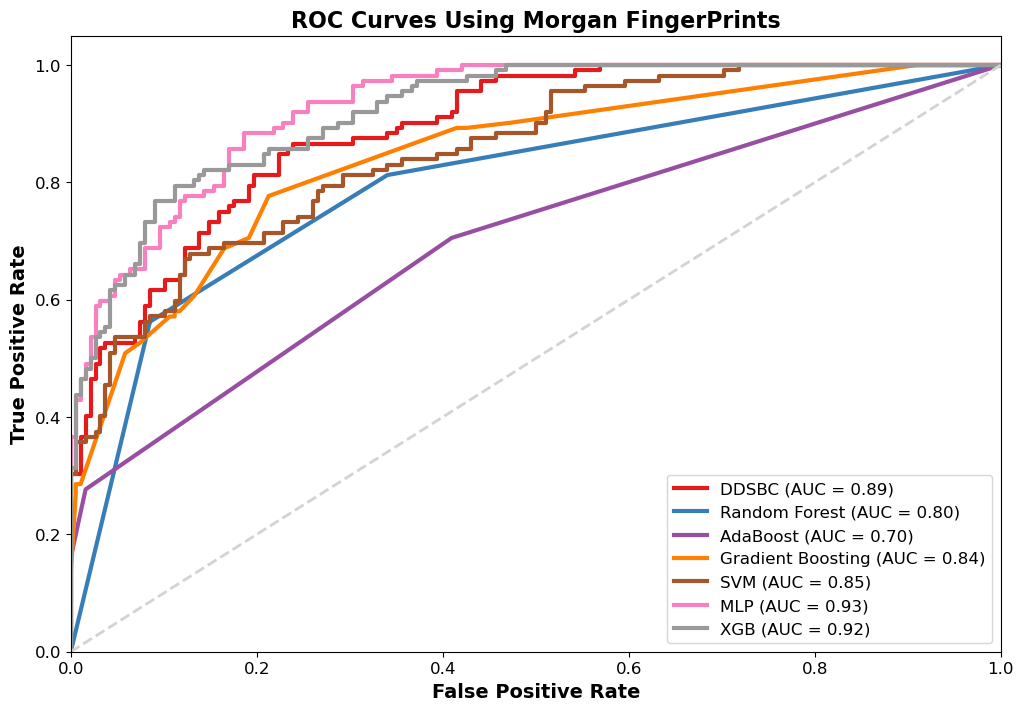

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc

# Set a larger figure size for better visibility
plt.figure(figsize=(12, 8))

# Define a color map
colors = plt.cm.Set1(np.linspace(0, 1, len(classifiers)))

for idx, (name, clf) in enumerate(classifiers.items()):
    clf.fit(X_smote, y_smote)  # Assuming clf is already trained if not fit here
    y_proba = clf.predict_proba(X_test)[:, 1]
    
    # Calculate ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    
    # Plot with a color from the color map
    plt.plot(fpr, tpr, color=colors[idx], lw=3, label=f'{name} (AUC = {roc_auc:.2f})', linestyle='-')

# Enhance the plot
plt.plot([0, 1], [0, 1], color='lightgray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=14, fontweight='bold')
plt.title('ROC Curves Using Morgan FingerPrints', fontsize=16, fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc="lower right", fontsize=12)
plt.savefig("Ablation_Study_Morganprints", dpi=900)
plt.show()



In [5]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, accuracy_score

# Continue from the previous ROC plotting code

# Placeholder for model evaluation metrics
evaluation_metrics = {}

for name, clf in classifiers.items():
    # Predictions
    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)[:, 1]
    
    # Metrics
    report = classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1'], output_dict=True)
    auc_roc = roc_auc_score(y_test, y_proba)
    accuracy = accuracy_score(y_test, y_pred)  # Calculate accuracy
    
    # Extracting True Positives, False Positives, False Negatives from the confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    # Calculating sensitivity (recall for the positive class)
    sensitivity = tp / (tp + fn)
    
    # Storing metrics
    evaluation_metrics[name] = {
        'Accuracy': accuracy,  # Add accuracy to the metrics
        'Precision (Class 1)': report['Class 1']['precision'],
        'Recall/Sensitivity (Class 1)': sensitivity,
        'F1-Score (Class 1)': report['Class 1']['f1-score'],
        'AUC-ROC': auc_roc,
    }

# Display evaluation metrics for each classifier
for model, metrics in evaluation_metrics.items():
    print(f"Metrics for {model}:")
    for metric_name, metric_value in metrics.items():
        print(f"{metric_name}: {metric_value:.4f}")
    print("\n")


Metrics for DDSBC:
Accuracy: 0.8067
Precision (Class 1): 0.7455
Recall/Sensitivity (Class 1): 0.7321
F1-Score (Class 1): 0.7387
AUC-ROC: 0.8911


Metrics for Random Forest:
Accuracy: 0.7833
Precision (Class 1): 0.7975
Recall/Sensitivity (Class 1): 0.5625
F1-Score (Class 1): 0.6597
AUC-ROC: 0.7972


Metrics for AdaBoost:
Accuracy: 0.6333
Precision (Class 1): 0.5064
Recall/Sensitivity (Class 1): 0.7054
F1-Score (Class 1): 0.5896
AUC-ROC: 0.7002


Metrics for Gradient Boosting:
Accuracy: 0.7800
Precision (Class 1): 0.7130
Recall/Sensitivity (Class 1): 0.6875
F1-Score (Class 1): 0.7000
AUC-ROC: 0.8443


Metrics for SVM:
Accuracy: 0.7533
Precision (Class 1): 0.6557
Recall/Sensitivity (Class 1): 0.7143
F1-Score (Class 1): 0.6838
AUC-ROC: 0.8522


Metrics for MLP:
Accuracy: 0.8233
Precision (Class 1): 0.7479
Recall/Sensitivity (Class 1): 0.7946
F1-Score (Class 1): 0.7706
AUC-ROC: 0.9288


Metrics for XGB:
Accuracy: 0.8133
Precision (Class 1): 0.7154
Recall/Sensitivity (Class 1): 0.8304
F1-Sco

SMOTE

/Users/iaamir/anaconda3/lib/python3.11/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


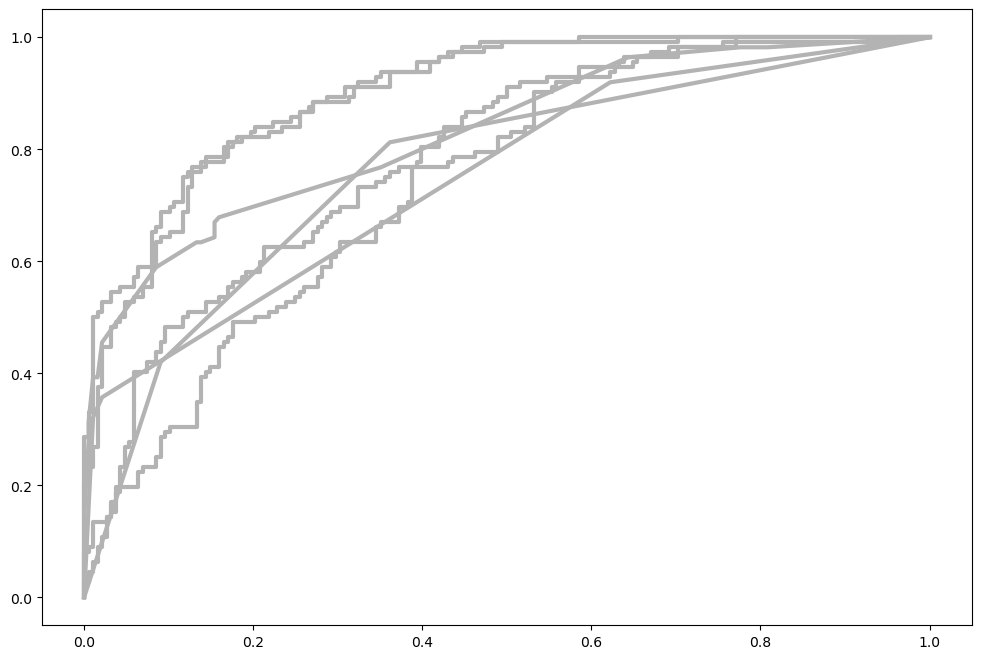

In [6]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Your preprocessing code (loading data, feature encoding, splitting, etc.) goes here
# Load datasets
dataseta = pd.read_csv('/Users/iaamir/Desktop/ONLY BRC DDI/pureBRC/b3.csv')
datasetb = pd.read_csv('/Users/iaamir/Desktop/ONLY BRC DDI/pureBRC/datasetb.csv')

# Ensure 'cell' columns are of the same data type in both datasets
dataseta['cell'] = dataseta['cell'].astype(str)
datasetb['cell'] = datasetb['cell'].astype(str)

# Align datasets by 'cell'
# Inner join ensures only matching rows are kept
combined_dataset = pd.merge(dataseta, datasetb, on='cell')

# Define the enhanced SMILES encoding function correctly
def enhanced_encode_smiles(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return [Descriptors.MolWt(mol), Descriptors.MolLogP(mol), Descriptors.NumHAcceptors(mol), Descriptors.NumHDonors(mol),
                Descriptors.NumRotatableBonds(mol), AllChem.CalcTPSA(mol), len(mol.GetRingInfo().AtomRings())]
    else:
        return [0] * 7

# Apply enhanced SMILES encoding to the combined dataset
combined_dataset['drug1_features'] = combined_dataset['drug1'].apply(enhanced_encode_smiles)
combined_dataset['drug2_features'] = combined_dataset['drug2'].apply(enhanced_encode_smiles)

# Process the features and PCA as before
features_combined = pd.DataFrame(np.concatenate((combined_dataset['drug1_features'].tolist(), combined_dataset['drug2_features'].tolist()), axis=1),
                                  columns=['MolWt1', 'MolLogP1', 'NumHAcceptors1', 'NumHDonors1', 'NumRotatableBonds1', 'TPSA1', 'RingCount1',
                                           'MolWt2', 'MolLogP2', 'NumHAcceptors2', 'NumHDonors2', 'NumRotatableBonds2', 'TPSA2', 'RingCount2'])

# Assuming the 'label' column is in 'dataseta', adjust if it's otherwise
y = combined_dataset['label'].values

# Normalize and PCA on gene expression data
scaler = StandardScaler()
gene_expression_data = combined_dataset.drop(columns=['cell', 'drug1', 'drug2', 'drug1_features', 'drug2_features', 'label'])  # Adjust as necessary to drop non-gene expression columns
gene_expression_scaled = scaler.fit_transform(gene_expression_data)
pca = PCA(n_components=0.95)
gene_expression_pca = pca.fit_transform(gene_expression_scaled)

# Combine PCA components with molecular features
X = np.concatenate([gene_expression_pca, features_combined.values], axis=1)

# Split data into training and testing sets (without using SMOTE)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define base learners and meta-learner for stacking model
base_learners = [
    ('rf', RandomForestClassifier(n_estimators=250, random_state=42)),
    ('ada', AdaBoostClassifier(n_estimators=250, random_state=42))
]

meta_learner = LogisticRegression(random_state=42)
ddsbc = StackingClassifier(estimators=base_learners, final_estimator=meta_learner, cv=5, n_jobs=-1)

# Define other classifiers for comparison
classifiers = {
    "DDSBC": ddsbc,  # Your ensemble stacking classifier named DDSBC
    "Random Forest": RandomForestClassifier(n_estimators=2, random_state=42),
    "AdaBoost": AdaBoostClassifier(n_estimators=2, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=2, random_state=42),
    "SVM": SVC(probability=True, random_state=2),
    "MLP": MLPClassifier(random_state=1),
    "XGB": XGBClassifier(min_child_weight=10, use_label_encoder=False, eval_metric='logloss', random_state=10)
}

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc

# Set a larger figure size for better visibility
plt.figure(figsize=(12, 8))

# Define a color map
colors = plt.cm.Set2(np.linspace(0, 1, len(classifiers)))

# Loop through classifiers to train, predict, and calculate ROC
for name, clf in classifiers.items():
    # Train the model without using SMOTE
    clf.fit(X_train, y_train)
    
    # Predict probabilities
    y_proba = clf.predict_proba(X_test)[:, 1]
    
    # Calculate ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    
    # Plot
    plt.plot(fpr, tpr, label=f'{name} (area = {roc_auc:.2f})', color=colors[idx], lw=3, linestyle='-')

# Plot formatting
#plt.plot([0, 1], [0, 1], color='lightgray', lw=2, linestyle='--')
#plt.xlim([0.0, 1.0])
#plt.ylim([0.0, 1.05])
#plt.xlabel('False Positive Rate', fontsize=14, fontweight='bold')
#plt.ylabel('True Positive Rate', fontsize=14, fontweight='bold')
#plt.title('ROC Curves without SMOTE', fontsize=16, fontweight='bold')
#plt.xticks(fontsize=12)
#plt.yticks(fontsize=12)
#plt.legend(loc="lower right", fontsize=12)
#plt.savefig("without_SMOTE", dpi=900)
#plt.show()



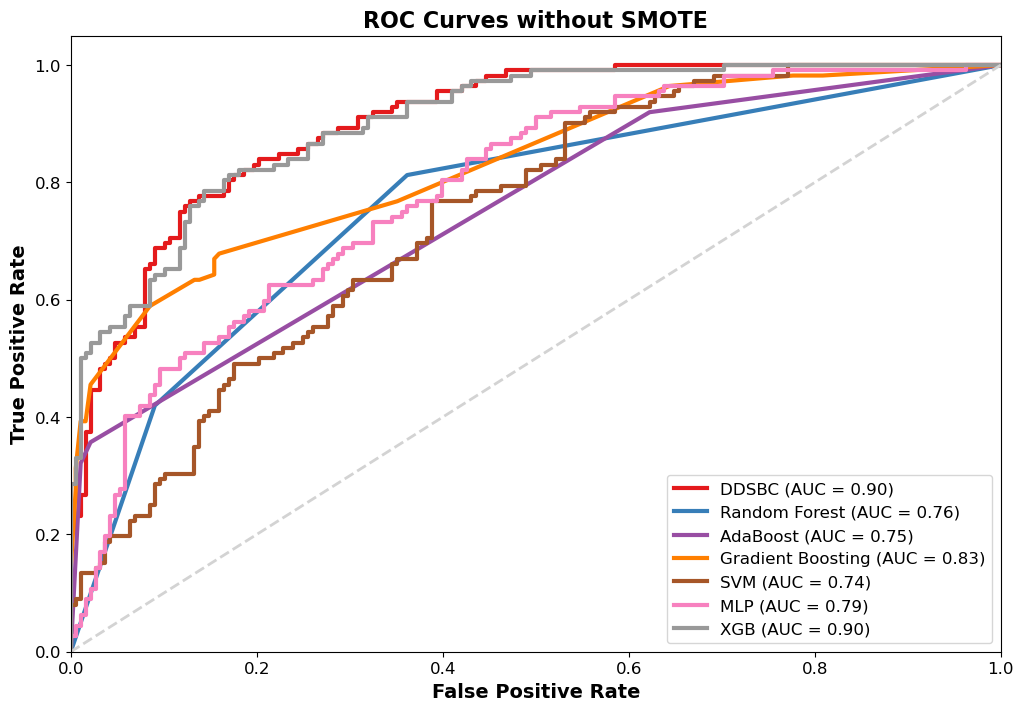

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc

# Set a larger figure size for better visibility
plt.figure(figsize=(12, 8))

# Define a color map
colors = plt.cm.Set1(np.linspace(0, 1, len(classifiers)))

# Loop through classifiers to train, predict, and calculate ROC
for idx, (name, clf) in enumerate(classifiers.items()):
    # Train the model without using SMOTE
    clf.fit(X_train, y_train)
    
    # Predict probabilities
    y_proba = clf.predict_proba(X_test)[:, 1]
    
    # Calculate ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    
    # Plot
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})', color=colors[idx], lw=3, linestyle='-')

# Plot formatting
plt.plot([0, 1], [0, 1], color='lightgray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=14, fontweight='bold')
plt.title('ROC Curves without SMOTE', fontsize=16, fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc="lower right", fontsize=12)
plt.savefig("without_SMOTE", dpi=900)
plt.show()


In [8]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, accuracy_score

# Continue from the previous ROC plotting code

# Placeholder for model evaluation metrics
evaluation_metrics = {}

for name, clf in classifiers.items():
    # Predictions
    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)[:, 1]
    
    # Metrics
    report = classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1'], output_dict=True)
    auc_roc = roc_auc_score(y_test, y_proba)
    accuracy = accuracy_score(y_test, y_pred)  # Calculate accuracy
    
    # Extracting True Positives, False Positives, False Negatives from the confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    # Calculating sensitivity (recall for the positive class)
    sensitivity = tp / (tp + fn)
    
    # Storing metrics
    evaluation_metrics[name] = {
        'Accuracy': accuracy,  # Add accuracy to the metrics
        'Precision (Class 1)': report['Class 1']['precision'],
        'Recall/Sensitivity (Class 1)': sensitivity,
        'F1-Score (Class 1)': report['Class 1']['f1-score'],
        'AUC-ROC': auc_roc,
    }

# Display evaluation metrics for each classifier
for model, metrics in evaluation_metrics.items():
    print(f"Metrics for {model}:")
    for metric_name, metric_value in metrics.items():
        print(f"{metric_name}: {metric_value:.4f}")
    print("\n")


Metrics for DDSBC:
Accuracy: 0.8333
Precision (Class 1): 0.7925
Recall/Sensitivity (Class 1): 0.7500
F1-Score (Class 1): 0.7706
AUC-ROC: 0.9020


Metrics for Random Forest:
Accuracy: 0.7267
Precision (Class 1): 0.7344
Recall/Sensitivity (Class 1): 0.4196
F1-Score (Class 1): 0.5341
AUC-ROC: 0.7646


Metrics for AdaBoost:
Accuracy: 0.7467
Precision (Class 1): 0.9091
Recall/Sensitivity (Class 1): 0.3571
F1-Score (Class 1): 0.5128
AUC-ROC: 0.7515


Metrics for Gradient Boosting:
Accuracy: 0.6267
Precision (Class 1): 0.0000
Recall/Sensitivity (Class 1): 0.0000
F1-Score (Class 1): 0.0000
AUC-ROC: 0.8295


Metrics for SVM:
Accuracy: 0.6600
Precision (Class 1): 0.7500
Recall/Sensitivity (Class 1): 0.1339
F1-Score (Class 1): 0.2273
AUC-ROC: 0.7409


Metrics for MLP:
Accuracy: 0.6433
Precision (Class 1): 0.5124
Recall/Sensitivity (Class 1): 0.9196
F1-Score (Class 1): 0.6581
AUC-ROC: 0.7867


Metrics for XGB:
Accuracy: 0.8233
Precision (Class 1): 0.7438
Recall/Sensitivity (Class 1): 0.8036
F1-Sco

/Users/iaamir/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/iaamir/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/iaamir/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


PCA at different values

PCA Ratio: 0.99, ROC AUC: 0.8978913373860182
PCA Ratio: 0.95, ROC AUC: 0.8978913373860182
PCA Ratio: 0.85, ROC AUC: 0.8978913373860182
PCA Ratio: 0.75, ROC AUC: 0.8889627659574468
PCA Ratio: 0.65, ROC AUC: 0.8889627659574468
PCA Ratio: 0.5, ROC AUC: 0.8889627659574468


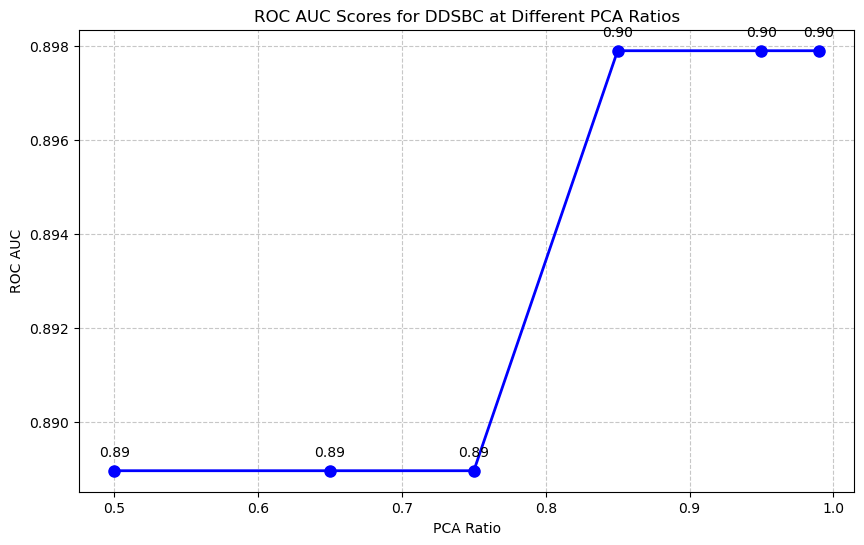

In [6]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load datasets
dataseta = pd.read_csv('/Users/iaamir/Desktop/ONLY BRC DDI/pureBRC/b3.csv')
datasetb = pd.read_csv('/Users/iaamir/Desktop/ONLY BRC DDI/pureBRC/datasetb.csv')

# Ensure 'cell' columns are of the same data type in both datasets
dataseta['cell'] = dataseta['cell'].astype(str)
datasetb['cell'] = datasetb['cell'].astype(str)

# Align datasets by 'cell'
combined_dataset = pd.merge(dataseta, datasetb, on='cell')

# Define the enhanced SMILES encoding function correctly
def enhanced_encode_smiles(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return [Descriptors.MolWt(mol), Descriptors.MolLogP(mol), Descriptors.NumHAcceptors(mol), Descriptors.NumHDonors(mol),
                Descriptors.NumRotatableBonds(mol), AllChem.CalcTPSA(mol), len(mol.GetRingInfo().AtomRings())]
    else:
        return [0] * 7

# Apply enhanced SMILES encoding to the combined dataset
combined_dataset['drug1_features'] = combined_dataset['drug1'].apply(enhanced_encode_smiles)
combined_dataset['drug2_features'] = combined_dataset['drug2'].apply(enhanced_encode_smiles)

# Process the features
features_combined = pd.DataFrame(np.concatenate((combined_dataset['drug1_features'].tolist(), combined_dataset['drug2_features'].tolist()), axis=1),
                                  columns=['MolWt1', 'MolLogP1', 'NumHAcceptors1', 'NumHDonors1', 'NumRotatableBonds1', 'TPSA1', 'RingCount1',
                                           'MolWt2', 'MolLogP2', 'NumHAcceptors2', 'NumHDonors2', 'NumRotatableBonds2', 'TPSA2', 'RingCount2'])

# Assuming the 'label' column is in 'dataseta', adjust if it's otherwise
y = combined_dataset['label'].values

# Normalize and PCA on gene expression data
scaler = StandardScaler()
gene_expression_data = combined_dataset.drop(columns=['cell', 'drug1', 'drug2', 'drug1_features', 'drug2_features', 'label'])
gene_expression_scaled = scaler.fit_transform(gene_expression_data)

# Define different PCA ratios
pca_ratios = [0.99, 0.95, 0.85, 0.75, 0.65, 0.50]

# Prepare lists to store AUC scores for DDSBC
auc_scores = []

for pca_ratio in pca_ratios:
    # PCA
    pca = PCA(n_components=pca_ratio)
    gene_expression_pca = pca.fit_transform(gene_expression_scaled)
    X = np.concatenate([gene_expression_pca, features_combined.values], axis=1)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Address class imbalance with SMOTE
    smote = SMOTE(random_state=42)
    X_smote, y_smote = smote.fit_resample(X_train, y_train)

    # Define and train DDSBC (Stacking Classifier)
    ddsbc = StackingClassifier(estimators=[('rf', RandomForestClassifier(n_estimators=250, random_state=42)),
                                           ('ada', AdaBoostClassifier(n_estimators=250, random_state=42))],
                                final_estimator=LogisticRegression(random_state=42), cv=5, n_jobs=-1)
    ddsbc.fit(X_smote, y_smote)

    # Predict probabilities
    y_proba = ddsbc.predict_proba(X_test)[:, 1]

    # Calculate ROC AUC and store
    roc_auc = roc_auc_score(y_test, y_proba)
    auc_scores.append(roc_auc)
    
    # Print the PCA ratio and corresponding ROC AUC score
    print(f"PCA Ratio: {pca_ratio}, ROC AUC: {roc_auc}")

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(pca_ratios, auc_scores, marker='o', color='b', linestyle='-', linewidth=2, markersize=8)
plt.xlabel('PCA Ratio')
plt.ylabel('ROC AUC')
plt.title('ROC AUC Scores for DDSBC at Different PCA Ratios')
plt.grid(linestyle='--', alpha=0.7)
for i, txt in enumerate(auc_scores):
    plt.annotate(f"{txt:.2f}", (pca_ratios[i], auc_scores[i]), textcoords="offset points", xytext=(0,10), ha='center')
plt.savefig("pca.png", dpi=900)
plt.show()
